In [1]:
#Vader Sentiment Analysis
#https://blog.quantinsti.com/vader-sentiment/
#!pip install vaderSentiment

import pandas as pd
import numpy as np

#!pip install yfinance --upgrade --no-cache-dir
#!pip install fix_yahoo_finance --upgrade --no-cache-dir
#import fix_yahoo_finance as yfi
#https://pypi.org/project/yfinance/

import pandas_datareader as pdr
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
#VADER has been included in the NLTK package itself. Module NLTK is used for natural language processing. 
#NLTK is an acronym for Natural Language Toolkit and is one of the leading platforms for working with human language data. Alternatively one may use

#!pip install nltk

#import nltk
#nltk.download('vader_lexicon')
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#analyzer = SentimentIntensityAnalyzer()

In [3]:
datapd = pdr.get_data_yahoo('ETH-USD', '2020-12-15', '2021-01-15') #newapi offers only one month analysis...
#datapd = yf.download("X", start="2017-01-01", end="2017-04-30")

datapd.shape

(33, 6)

In [4]:
datapd.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-15,596.247742,580.628784,586.021790,589.355591,9326645840,589.355591
2020-12-16,636.640320,582.039124,589.378662,636.181824,15817248373,636.181824
2020-12-17,673.834229,628.749390,636.154175,642.868958,25479532147,642.868958
2020-12-18,662.699097,632.356079,642.916992,654.811951,15756303983,654.811951
2020-12-19,668.769592,646.616211,654.624207,659.297913,12830893778,659.297913
2020-12-20,659.923706,625.014465,659.185059,638.290833,13375855442,638.290833
2020-12-21,646.846558,600.836060,638.315186,609.817871,14419493621,609.817871
2020-12-22,635.076599,589.552002,609.420532,634.854187,14745890080,634.854187
2020-12-23,637.122803,560.364258,634.824585,583.714600,15261413038,583.714600


In [5]:
#Using Simple Moving Crossover Strategy to generate trade calls

#1-month period. Should pick fast SMA in order to get more signals
datapd['1_SMA'] = datapd['Close'].rolling(window=3).mean()
datapd['2_SMA'] = datapd['Close'].rolling(window=9).mean()

datapd = datapd[datapd['2_SMA'].notna()]

# SMA trade calls
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(datapd)-1):
    if ((datapd['1_SMA'].values[i] < datapd['2_SMA'].values[i]) & (datapd['1_SMA'].values[i+1] > datapd['2_SMA'].values[i+1])):
        print("Trade Call for {row} is Buy.".format(row=datapd.index[i].date()))
        Trade_Buy.append(i)
    elif ((datapd['1_SMA'].values[i] > datapd['2_SMA'].values[i]) & (datapd['1_SMA'].values[i+1] < datapd['2_SMA'].values[i+1])):
        print("Trade Call for {row} is Sell.".format(row=datapd.index[i].date()))
        Trade_Sell.append(i)

Trade Call for 2020-12-26 is Buy.
Trade Call for 2021-01-11 is Sell.
Trade Call for 2021-01-15 is Buy.


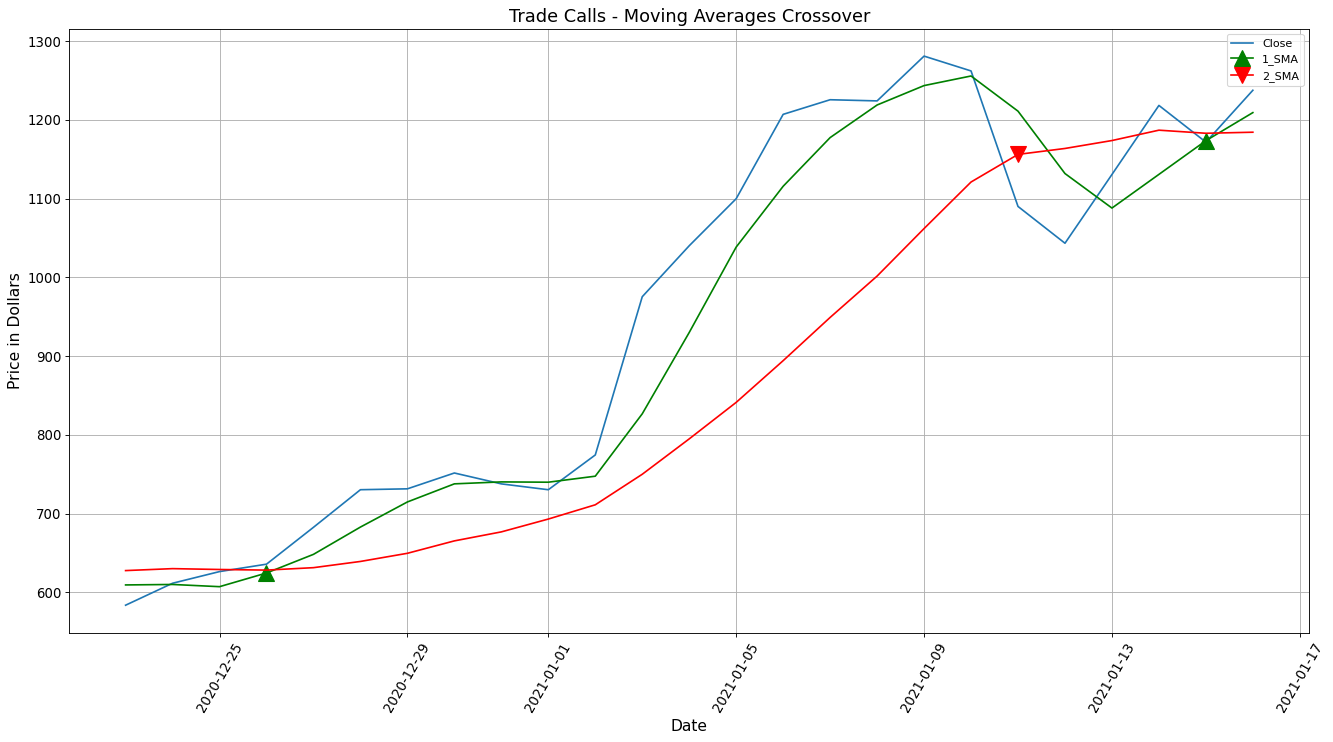

In [6]:
#plotting trades
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(datapd.index, datapd['Close'])
plt.plot(datapd.index, datapd['1_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(datapd.index, datapd['2_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - Moving Averages Crossover', fontsize = 16)
plt.legend(['Close','1_SMA','2_SMA'])
plt.grid()
plt.show() 

In [7]:
# News API is a simple HTTP REST API that returns JSON files with breaking news headlines and search for articles from over 30,000 news sources and blogs.
# https://newsapi.org/
# Your API key is: 833c5860f7a74851a42ed5be297f4bea

# Using developer mode of Newsapi.org to extract news headlines

import requests 
# Define the endpoint
url = 'https://newsapi.org/v2/everything?'

# Specify the query and number of returns
parameters = {
    'q': 'Ethereum' and 'Vitalik', # query phrase
    'from_param': '2020-10-15', #not working...takes last 30 days
    'to': '2021-01-15',
    'sortBy': 'popularity', # articles from popular sources and publishers come first
    'pageSize': 100,  # maximum is 100 for developer version
    'apiKey': '833c5860f7a74851a42ed5be297f4bea', # API key
}

# Make the request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

news_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

final_news = news_df.loc[:,['publishedAt','title']]
final_news['publishedAt'] = pd.to_datetime(final_news['publishedAt'])
final_news.sort_values(by='publishedAt',inplace=True)

# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay

# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Apply the above function to get the trading time for each news headline
final_news["trading_time"] = final_news["publishedAt"].apply(get_trade_open)

final_news = final_news[pd.notnull(final_news['trading_time'])]
final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)

In [8]:
# Getting compound VADER scores for extracted news headlines
#only last month data...free plan

cs = []
for row in range(len(final_news)):
    cs.append(analyzer.polarity_scores(final_news['title'].iloc[row])['compound'])

final_news['compound_vader_score'] = cs
final_news = final_news[(final_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

final_news

,publishedAt,title,trading_time,Date,compound_vader_score
0,2020-12-16 21:54:25+00:00,"'Be my Santa, please' — Chainlink user offers ...",2020-12-17 13:30:00+00:00,2020-12-17,0.5574
1,2020-12-17 21:56:00+00:00,"The best business, finance and retirement acco...",2020-12-18 13:30:00+00:00,2020-12-18,0.6369
2,2020-12-20 20:27:00+00:00,Why contests are better than grants for a heal...,2020-12-21 13:30:00+00:00,2020-12-21,0.7579
3,2020-12-22 12:55:32+00:00,Buterin Blasts Ripple’s Defence Against Pendin...,2020-12-22 13:30:00+00:00,2020-12-22,-0.1280
4,2020-12-26 14:00:00+00:00,Top 10 tweets of the year,2020-12-28 13:30:00+00:00,2020-12-28,0.2023
5,2020-12-29 20:10:52+00:00,"'Christmas magic,' says Chainlink user who rec...",2020-12-30 13:30:00+00:00,2020-12-30,-0.3400
6,2020-12-31 06:00:53+00:00,Why StableCoins are so important (but also so ...,2020-12-31 13:30:00+00:00,2020-12-31,-0.1571
7,2021-01-02 10:48:16+00:00,We need to bring community and sustainability ...,2021-01-04 13:30:00+00:00,2021-01-04,0.6369
8,2021-01-05 01:40:00+00:00,Donald Trump’s Former Comms Director Made A Sh...,2021-01-05 13:30:00+00:00,2021-01-05,-0.3818
9,2021-01-06 03:30:00+00:00,OXBTC: Challenges and Opportunities on the Lon...,2021-01-06 13:30:00+00:00,2021-01-06,0.4404


In [9]:
#Retaining extreme (max and min) compound scores for same Day news headlines
unique_dates = final_news['Date'].unique()
grouped_dates = final_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

In [10]:
# Summing and calculating final VADER scores

final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores

extreme_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-12-17,0.5574,0.000,0.5574
1,2020-12-18,0.6369,0.000,0.6369
2,2020-12-21,0.7579,0.000,0.7579
3,2020-12-22,0.0000,-0.128,-0.1280
4,2020-12-28,0.2023,0.000,0.2023


In [11]:
#Using final compound VADER scores with threshold to generate trade calls
#Considering the volatile behavior of markets these days, we'll use 0.20 as threshold value for making trade calls in our model.

# VADER trade calls - with threshold
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

Trade Call for 2020-12-17 is Buy.
Trade Call for 2020-12-18 is Buy.
Trade Call for 2020-12-21 is Buy.
Trade Call for 2020-12-28 is Buy.
Trade Call for 2020-12-30 is Sell.
Trade Call for 2021-01-04 is Buy.
Trade Call for 2021-01-05 is Sell.
Trade Call for 2021-01-06 is Buy.
Trade Call for 2021-01-07 is Sell.
Trade Call for 2021-01-11 is Buy.
Trade Call for 2021-01-13 is Sell.


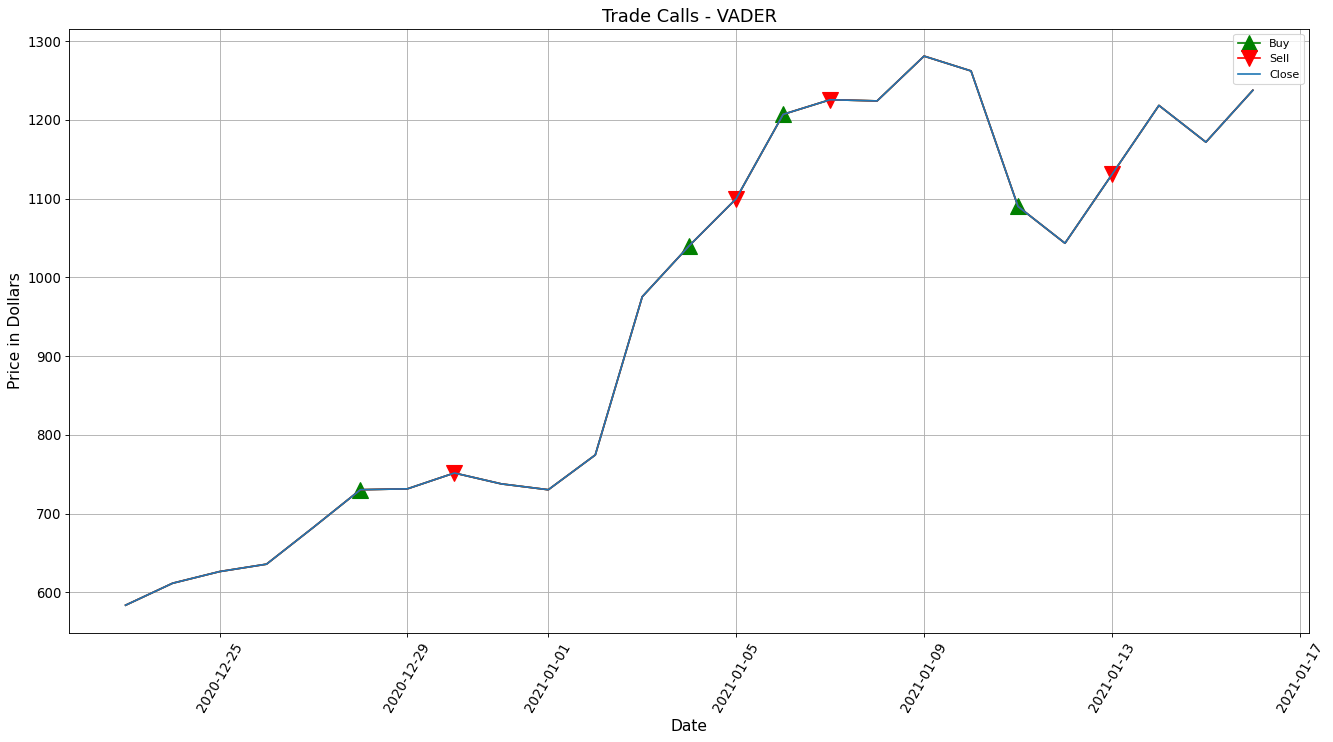

In [12]:
vader_buy = []
for i in range(len(datapd)):
    if datapd.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(datapd)):
    if datapd.index[i].date() in vader_Sell:
        vader_sell.append(i)
        
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(datapd.index, datapd['Close'],'-^', markevery=vader_buy, ms=15, color='green')
plt.plot(datapd.index, datapd['Close'],'-v', markevery=vader_sell, ms=15, color='red')
plt.plot(datapd.index, datapd['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

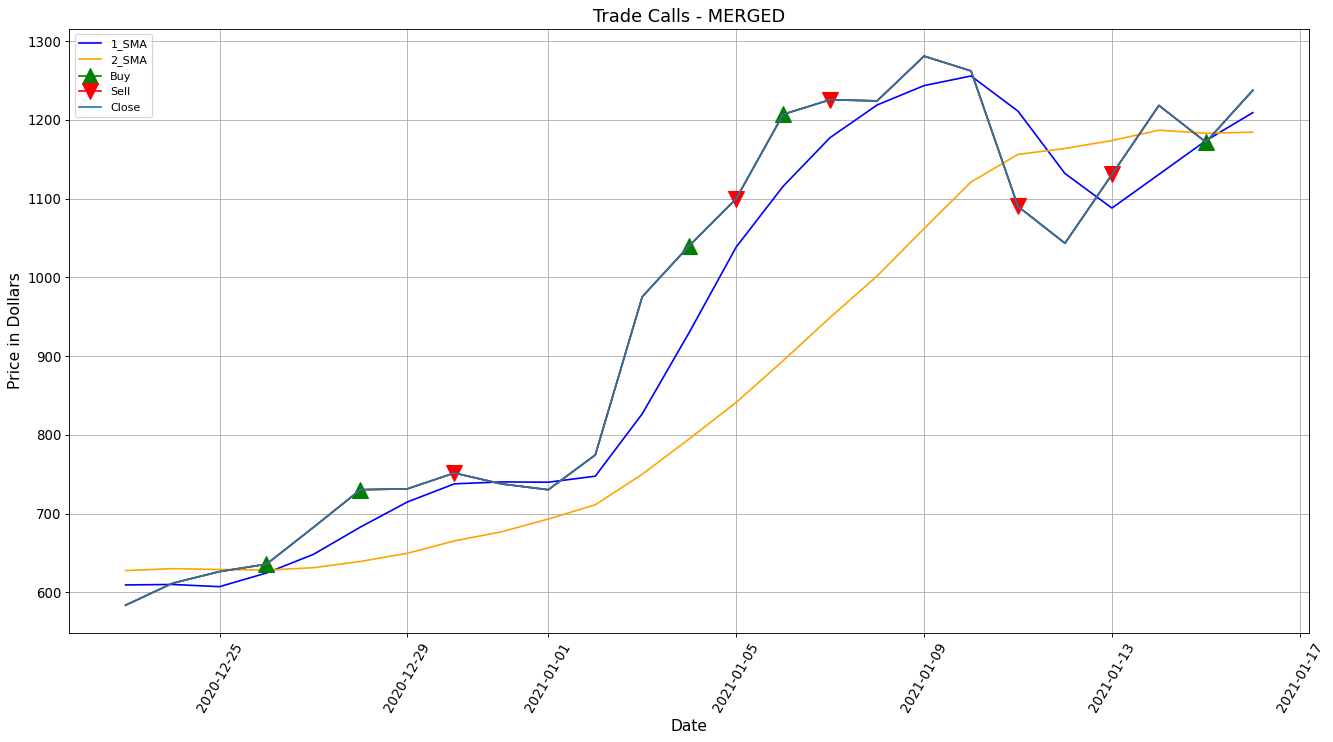

In [13]:
# Merging Trade Signals with SMA at higher priority and VADER for refining

#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(datapd.index, datapd['1_SMA'], color='blue')
plt.plot(datapd.index, datapd['2_SMA'], color='orange')
plt.plot(datapd.index, datapd['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(datapd.index, datapd['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(datapd.index, datapd['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['1_SMA','2_SMA','Buy','Sell','Close'])
plt.grid()
plt.show() 

In [14]:
#Although we used SMA as our primary technical indicator, one won't face any hassle while using VADER with others too.

#Clearly, incorporating VADER sentiment analysis gave us an edge over raw SMA model and this speaks about the power of sentiment analysis in Algorithmic Trading.

#Note that, in case of conflict we prioritized SMA and took VADER signals only for refining purposes.

#Before deploying any algorithmic model, it's very important to backtest, add safeguards, paper trade and keep on optimizing.